In [39]:
from PIL import Image
import numpy as np
import glob
from IPython.display import display
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cv2
import shutil

In [101]:
import keras
from keras.models import Sequential,Model,Input
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D,Flatten,Dense,Reshape,Conv2DTranspose,BatchNormalization

# Data Preparation.
<h3> The main dataset is in the folder : indoorCVPR_09. </h3>
<h3>From that we read 20 images from each category. Then we resize the image to 128 * 128 and save it in data/color_images folder. </h3> 
<h3> Its grayscale counterpart is saved in data/gray_images folder. </h3>

In [81]:
base_dir = 'indoorCVPR_09/'
converted_size = 128

In [50]:
def save_images(baseDir,converted_size):
    count =1 
    try:
        for subdir, dirs, files in os.walk(baseDir):
            file_from_each_seg = 0
            
            for file in files:
                filename = os.path.join(subdir, file)

                if file_from_each_seg == 50:
                    break
                image = cv2.imread(filename)

                if image is not None:
                    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                    image = cv2.resize(image, (converted_size, converted_size))
                    gray_img = cv2.resize(gray_img, (converted_size, converted_size))

                    cv2.imwrite("data/gray_images/gray_" +str(count) +".jpg", gray_img)
                    cv2.imwrite("data/color_images/color_" +str(count) +".jpg", image)
                    count += 1
                    file_from_each_seg += 1
                else:
                    print('Coorupt image: ' ,filename)
    except Exception as e: 
        print(e)
        print('Exception occured in  file: ' ,filename)
    return count

In [17]:
def load_image_in_arrays(count): 
    color_images = []

    for i in range(1, count):
        img = cv2.imread("data/color_images/color_" +str(i) +".jpg" )
        color_images.append(np.array(img))

    color_images_arr = np.asarray(color_images)
    print(color_images_arr.shape)

    gray_images = []

    for i in range(1,  count):
        img = cv2.imread("data/gray_images/gray_" +str(i) +".jpg", 0)    
        gray_images.append(np.array(img))

    gray_images_arr = np.asarray(gray_images)
    gray_images_arr = gray_images_arr[:,:,:,np.newaxis]
    print(gray_images_arr.shape)
    
    #Normalize the images
    gray_images_arr = gray_images_arr.astype('float32') / 255
    color_images_arr = color_images_arr.astype('float32') / 255
    
    return gray_images_arr,color_images_arr

In [44]:
def create_directory():
    if os.path.exists('data'):
        cleanup()
    os.mkdir('data')
    os.mkdir('data/gray_images')
    os.mkdir('data/color_images')
    os.mkdir('data/output')        

In [41]:
def cleanup():
    shutil.rmtree('data')

# Train Test Split

In [19]:
def returnTestTrainSplitData(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, shuffle= True)
    print(' X_train shape %s . Y_train shape %s ' %(X_train.shape,y_train.shape))
    print(' X_test shape %s . Y_test shape %s ' %(X_test.shape,y_test.shape))
    return X_train, X_test,y_train,y_test

# Model related functions

In [108]:
def build_model(input_dim,loss,optimizer):
    
    input_layer = Input(shape=input_dim)

    # encoder
    h = Conv2D(128, (2,2), activation='relu', padding='same')(input_layer)
    h = MaxPooling2D((2, 2), padding='same')(h)
    
    # decoder
    h = UpSampling2D((2, 2))(h)
    h = Conv2D(32, (2,2), activation='relu', padding='same')(h)
    h = Conv2D(1, (2,2), activation=None, padding='same')(h)
  
    model = Model(input_layer, h)
    
    model.compile(optimizer=optimizer,loss=loss)
    model.summary()
    
    return model

In [63]:
def train_model(model,batch_size,epochs,X_train,y_train):
    history=model.fit(
        X_train, 
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    return history

# Plot  loss

In [64]:
def plotTrainValLoss(history,epochs):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('mean_squared_error  Loss')

    # list of epoch numbers
    x = list(range(1,epochs+1))

    ty = history.history['loss']
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    plt.show()
    fig.canvas.draw()

# Prediction done after training

In [65]:
def predict(X_test,y_test,model):
    count = 1
    generated_image = model.predict(X_test)
    generated_image = generated_image * 255.0
    generated_image = np.floor(generated_image)
    
    y_test = y_test * 255.0
    y_test = np.floor(y_test)
    
    for image in generated_image:
        cv2.imwrite("data/output/generated_" +str(count) +".jpg", image)
        count += 1
    count = 1
    for image in y_test:
        cv2.imwrite("data/output/test_" +str(count) +".jpg", image)
        count += 1

# Driver function

In [110]:
def data_creation(base_dir,converted_size):
    
    #Step 1: Create data directory
    create_directory()
    
    #Step 2: From the large dataset get 50 images from each category and save it to a fresh folder
    count = save_images(base_dir,converted_size)  
    
    #Step 3: Read the small dataset into arrays
    gray_images_arr,color_images_arr = load_image_in_arrays(count)
    
    #Step 4: Get test train split
    X_train, X_test,y_train,y_test = returnTestTrainSplitData(color_images_arr, gray_images_arr)
    return X_train, X_test,y_train,y_test

In [105]:
def model(X_train, X_test,y_train, y_test, epochs=10,batch_size = 32,loss = 'mean_squared_error',optimizer = 'adam'):
    batch_size = 32
    input_dim = (128,128,3)
    
    #Step 1: Get the model
    model = build_model(input_dim,loss,optimizer)
    
    #Step 2: Train the model
    history = train_model(model,batch_size,epochs,X_train,y_train)
    
    #print(history)
    #Step 3: Plot loss
    plotTrainValLoss(history,epochs)
    
    #Step 4: Make predictions and save 
    predict(X_test,y_test,model) 

In [111]:
X_train, X_test,y_train,y_test = data_creation(base_dir,converted_size)

Coorupt image:  indoorCVPR_09/computerroom\aula_informatica_gif.jpg
Coorupt image:  indoorCVPR_09/fastfood_restaurant\connies_gif.jpg
Coorupt image:  indoorCVPR_09/gameroom\gameroom_gif.jpg
(1400, 128, 128, 3)
(1400, 128, 128, 1)
 X_train shape (980, 128, 128, 3) . Y_train shape (980, 128, 128, 1) 
 X_test shape (420, 128, 128, 3) . Y_test shape (420, 128, 128, 1) 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 128)     1664      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 32)      16416     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 1)       129       
Total params: 18,209
Trainable params: 18,209
Non-trainable params: 0
_________________________________________________________________
Epoch 

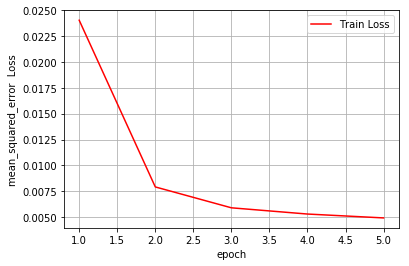

In [112]:
model(X_train, X_test,y_train,y_test,epochs=5)